In [ ]:
# 导入库
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
# 在 Notebook 中显示高清图
try:
    from matplotlib_inline import backend_inline
    backend_inline.set_matplotlib_formats('svg')
except Exception:
    pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [ ]:
# 数据变换：训练时加入小幅数据增强
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
# 下载并创建数据集
data_dir = Path('./data')
train_dataset = datasets.MNIST(root=str(data_dir), train=True, download=True, transform=train_transform)
test_dataset  = datasets.MNIST(root=str(data_dir), train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=2)
print('Train samples:', len(train_dataset), 'Test samples:', len(test_dataset))

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 502: Bad Gateway



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Train samples: 60000 Test samples: 10000


In [ ]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
        )
    def forward(self, x):
        return nn.functional.relu(x + self.net(x))

In [ ]:
# 改进的 CNN：加入 BatchNorm、Dropout、AdaptiveAvgPool
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(16),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32),
            nn.AdaptiveAvgPool2d((1,1)), 
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 10)
        )
    def forward(self, x):
        return self.net(x)

# 权重初始化
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
# 查看网络并测试一次前向传播输出形状
model = ImprovedCNN()
model.apply(init_weights)
X = torch.rand(size=(1,1,28,28))
y = model(X)
print('Output shape:', y.shape)  

Output shape: torch.Size([1, 10])


In [ ]:
# 将模型移动到设备并设置训练工具
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  

ImprovedCNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ResidualBlock(
      (n

In [ ]:
# 训练循环
epochs = 8
train_losses = []
train_accs = []
test_accs = []
for epoch in range(1, epochs+1):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
    scheduler.step()
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    # 在测试集上评估
    model.eval()
    correct_t = 0
    total_t = 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            _, pred_t = torch.max(out_t, dim=1)
            correct_t += (pred_t == y_t).sum().item()
            total_t += y_t.size(0)
    test_acc = 100.0 * correct_t / total_t
    test_accs.append(test_acc)
    print(f'Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.2f}% - Test Acc: {test_acc:.2f}%')

Epoch 1/8 - Loss: 0.6945 - Train Acc: 78.97% - Test Acc: 98.35%
Epoch 2/8 - Loss: 0.2097 - Train Acc: 94.27% - Test Acc: 98.91%
Epoch 3/8 - Loss: 0.1472 - Train Acc: 95.96% - Test Acc: 99.18%
Epoch 4/8 - Loss: 0.1132 - Train Acc: 96.85% - Test Acc: 99.16%
Epoch 5/8 - Loss: 0.0999 - Train Acc: 97.18% - Test Acc: 99.30%
Epoch 6/8 - Loss: 0.0928 - Train Acc: 97.34% - Test Acc: 99.18%
Epoch 7/8 - Loss: 0.0817 - Train Acc: 97.70% - Test Acc: 99.48%
Epoch 8/8 - Loss: 0.0791 - Train Acc: 97.70% - Test Acc: 99.44%


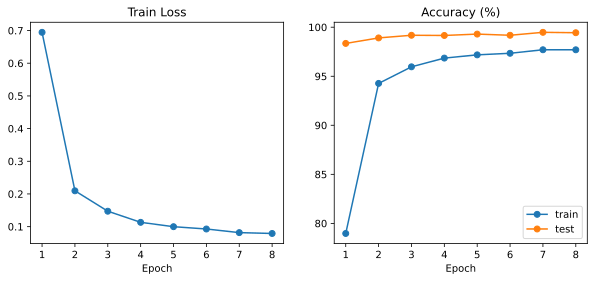

In [9]:
# 绘制训练损失与精度曲线
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, '-o')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accs)+1), train_accs, '-o', label='train')
plt.plot(range(1, len(test_accs)+1), test_accs, '-o', label='test')
plt.title('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Final Test Accuracy: 99.44%


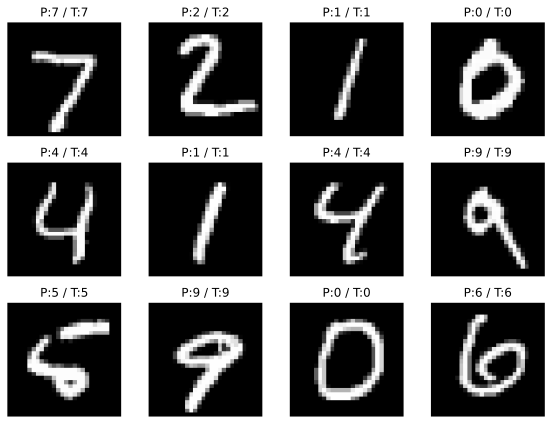

In [10]:
# 在测试集上做最终评估并展示若干样例预测
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        _, pred = torch.max(out, dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
final_acc = 100.0 * correct / total
print(f'Final Test Accuracy: {final_acc:.2f}%')

# 显示若干预测样例
def imshow(img, ax=None):
    img = img.squeeze().cpu().numpy()
    if ax is None:
        plt.imshow(img, cmap='gray')
    else:
        ax.imshow(img, cmap='gray')

examples_shown = 0
plt.figure(figsize=(8,6))
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        _, pred = torch.max(out, dim=1)
        for i in range(x.size(0)):
            if examples_shown >= 12:
                break
            ax = plt.subplot(3,4,examples_shown+1)
            imshow(x[i], ax=ax)
            ax.set_title(f'P:{int(pred[i].cpu())} / T:{int(y[i].cpu())}')
            ax.axis('off')
            examples_shown += 1
        if examples_shown >= 12:
            break
plt.tight_layout()
plt.show()

In [ ]:
# 保存模型参数
save_path = Path('./mnist_cnn.pth')
torch.save(model.state_dict(), str(save_path))
print('Model saved to', save_path)